Drive already mounted at /content/grive/; to attempt to forcibly remount, call drive.mount("/content/grive/", force_remount=True).


100%|██████████| 1000/1000 [00:03<00:00, 252.09it/s]


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4096, out_features=5, bias=True)
  )
)
Epoch :  1 	 loss : tensor(1.6872, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(2.3314, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(1.0893, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(0.8721, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(0.9516, grad_fn=<NllLossBackward0>)
Epoc

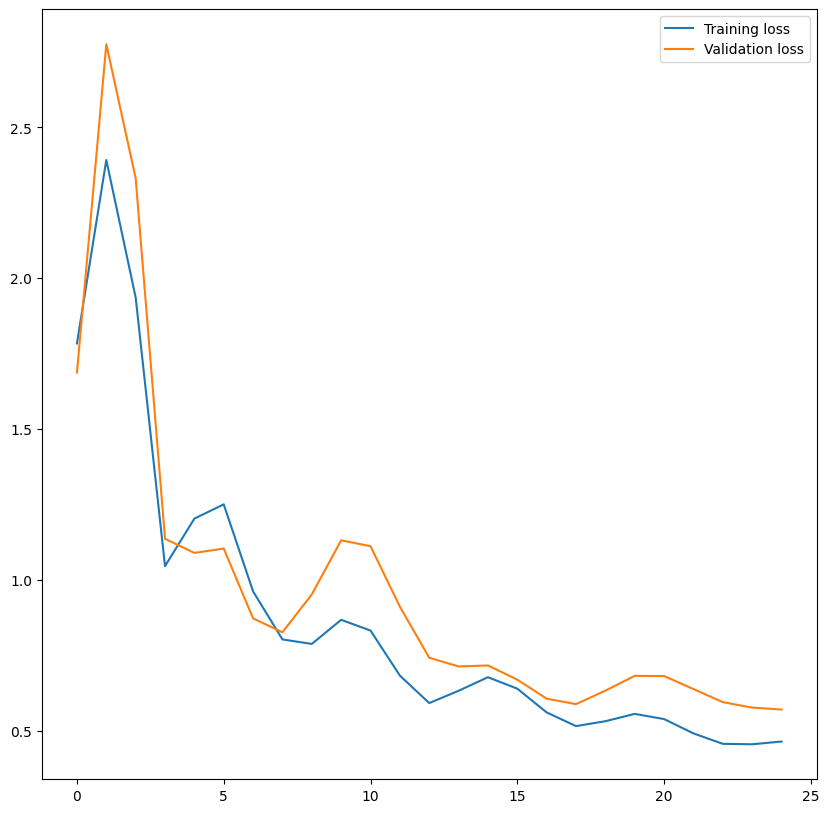

0.7666666666666667
0.76


array([0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 3, 2, 1, 0, 4, 1, 2, 3,
       2, 3, 0, 1, 0, 2, 0, 3, 1, 2, 0, 1, 1, 2, 0, 4, 0, 2, 2, 1, 3, 1,
       3, 1, 2, 3, 0, 2])

In [ ]:
# -*- coding: utf-8 -*-
"""chart_image_cnn.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/15yOdWdLTDIUFBuIEv17B4_skmpKCR_xe
"""

# Commented out IPython magic to ensure Python compatibility.
# importing the libraries
import numpy as np
import pandas as pd

from google.colab import drive
import pdb; 

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
# %matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

drive.mount('/content/grive/')

"""# New section"""

# loading dataset
train = pd.read_csv('/content/grive/MyDrive/Colab Notebooks/mlassignments/fractal3/charts/train_val.csv')
#test = pd.read_csv('test_ScVgIM0/test.csv')

#sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')
train = train.replace(to_replace = "vbar_categorical", value = 0)
train = train.replace(to_replace = "hbar_categorical", value =1)
train = train.replace(to_replace = "line", value =2)
train = train.replace(to_replace = "pie", value =3)
train = train.replace(to_replace = "dot_line", value = 4)

train.head()

# loading training images
train_img = []
for img_name in tqdm(train['image_index']):
    # defining the image path
    image_path = '/content/grive/MyDrive/Colab Notebooks/mlassignments/fractal3/charts/train/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train['type'].values
train_x.shape

# visualizing images
i = 0
plt.figure(figsize=(10,10))
#plt.subplot(221), plt.imshow(train_x[i])
#plt.subplot(222), plt.imshow(train_x[i+25])
#plt.subplot(223), plt.imshow(train_x[i+50])
#plt.subplot(224), plt.imshow(train_x[i+75])

# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

# converting training images into torch format
num_images = train_x.shape[0]
train_x = train_x.reshape(num_images, 4, 128, 128)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

# converting validation images into torch format
val_x = val_x.reshape(100, 4, 128, 128)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 32 * 32, 5)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train.detach())  # Detach gradients
    val_losses.append(loss_val.detach())      # Detach gradients

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# prediction for training set
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
print(accuracy_score(train_y, predictions))

# prediction for validation set
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
print(accuracy_score(val_y, predictions))

# loading test images
test_img = []
for img_name in range(50):
    # defining the image path
    image_path = '/content/grive/MyDrive/Colab Notebooks/mlassignments/fractal3/charts/test/' + str(img_name) + '.png'
     # reading the image
    img = imread(image_path)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)
test_x.shape

# converting training images into torch format
test_x = test_x.reshape(50, 4, 128, 128)
test_x  = torch.from_numpy(test_x)
test_x.shape

# generating predictions for test set
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
predictions

# replacing the label with prediction
#sample_submission['label'] = predictions
#sample_submission.head()

# saving the file
#sample_submission.to_csv('submission.csv', index=False)